In [1]:
import numpy as np
import autograd.numpy as anp      
import scipy, scipy.ndimage, scipy.sparse, scipy.sparse.linalg 

In [2]:
import matplotlib.pyplot as plt  
import gym
from gym import spaces
import random
import numpy as np
import autograd.numpy as anp  
from gym.utils import seeding

In [3]:
from hbaselines.algorithms import RLAlgorithm
from hbaselines.goal_conditioned.td3 import GoalConditionedPolicy

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
    
def get_args(normals, forces, density=1e-4):  # Manage the problem setup parameters
    width = normals.shape[0] - 1
    height = normals.shape[1] - 1
    fixdofs = np.flatnonzero(normals.ravel())
    alldofs = np.arange(2 * (width + 1) * (height + 1))
    freedofs = np.sort(list(set(alldofs) - set(fixdofs)))
    params = {
      # material properties
      'young': 1, 'young_min': 1e-9, 'poisson': 0.3, 'g': 0,
      # constraints
      'density': density, 'xmin': 0.001, 'xmax': 1.0,
      # input parameters
      'nelx': width, 'nely': height, 'mask': 1, 'penal': 3.0, 'filter_width': 1,
      'freedofs': freedofs, 'fixdofs': fixdofs, 'forces': forces.ravel(),
      # optimization parameters
      'opt_steps': 80, 'print_every': 10}
    return ObjectView(params)

def mbb_beam(width=4, height=4, density=1e-4, y=1, x=0, rd=-1):  # textbook rl_beam example
    normals = np.zeros((width + 1, height + 1, 2))
    normals[0, 0, x] = 1
    normals[0, 0, y] = 1
    normals[0, -1, x] = 1
    normals[0, -1, y] = 1
    forces = np.zeros((width + 1, height + 1, 2))
    forces[-1, rd, y] = -1
    return normals, forces, density

def young_modulus(x, e_0, e_min, p=3):
    return e_min + x ** p * (e_0 - e_min)

def physical_density(x, args, volume_contraint=False, use_filter=True):
    x = args.mask * x.reshape(args.nely, args.nelx)  # reshape from 1D to 2D
    return gaussian_filter(x, args.filter_width) if use_filter else x  # maybe filter

def mean_density(x, args, volume_contraint=False, use_filter=True):
    return anp.mean(physical_density(x, args, volume_contraint, use_filter)) / anp.mean(args.mask)

def objective(x, args, volume_contraint=False, use_filter=True):
    kwargs = dict(penal=args.penal, e_min=args.young_min, e_0=args.young)
    x_phys = physical_density(x, args, volume_contraint=volume_contraint, use_filter=use_filter)
    ke     = get_stiffness_matrix(args.young, args.poisson)  # stiffness matrix
    u      = displace(x_phys, ke, args.forces, args.freedofs, args.fixdofs, **kwargs)
    c      = compliance(x_phys, u, ke, **kwargs)
    return c

def gaussian_filter(x, width): # 2D gaussian blur/filter
    return scipy.ndimage.gaussian_filter(x, width, mode='reflect')

def _gaussian_filter_vjp(ans, x, width): # gives the gradient of orig. function w.r.t. x
    del ans, x  # unused
    return lambda g: gaussian_filter(g, width)

def compliance(x_phys, u, ke, *, penal=3, e_min=1e-9, e_0=1):
    nely, nelx = x_phys.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords for the index map

    n1 = (nely+1)*(elx+0) + (ely+0)  # nodes
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    all_ixs = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    u_selected = u[all_ixs]  # select from u matrix

    ke_u = anp.einsum('ij,jkl->ikl', ke, u_selected)  # compute x^penal * U.T @ ke @ U
    ce = anp.einsum('ijk,ijk->jk', u_selected, ke_u)
    C = young_modulus(x_phys, e_0, e_min, p=penal) * ce.T
    return anp.sum(C)

def get_stiffness_matrix(e, nu):  # e=young's modulus, nu=poisson coefficient
    k = anp.array([1/2-nu/6, 1/8+nu/8, -1/4-nu/12, -1/8+3*nu/8,
                -1/4+nu/12, -1/8-nu/8, nu/6, 1/8-3*nu/8])
    return e/(1-nu**2)*anp.array([[k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
                               [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
                               [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
                               [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
                               [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
                               [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
                               [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
                               [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]]])
    
def get_k(stiffness, ke):
    # Constructs sparse stiffness matrix k (used in the displace fn)
    # First, get position of the nodes of each element in the stiffness matrix
    nely, nelx = stiffness.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords
    ely, elx = ely.reshape(-1, 1), elx.reshape(-1, 1)

    n1 = (nely+1)*(elx+0) + (ely+0)
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    edof = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    edof = edof.T[0]
    x_list = anp.repeat(edof, 8)  # flat list pointer of each node in an element
    y_list = anp.tile(edof, 8).flatten()  # flat list pointer of each node in elem

    # make the global stiffness matrix K
    kd = stiffness.T.reshape(nelx*nely, 1, 1)
    value_list = (kd * anp.tile(ke, kd.shape)).flatten()
    return value_list, y_list, x_list

def displace(x_phys, ke, forces, freedofs, fixdofs, *, penal=3, e_min=1e-9, e_0=1):
    # Displaces the load x using finite element techniques (solve_coo=most of runtime)
    stiffness = young_modulus(x_phys, e_0, e_min, p=penal)
    k_entries, k_ylist, k_xlist = get_k(stiffness, ke)

    index_map, keep, indices = _get_dof_indices(freedofs, fixdofs, k_ylist, k_xlist)

    u_nonzero = solve_coo(k_entries[keep], indices, forces[freedofs], sym_pos=True)
    u_values = anp.concatenate([u_nonzero, anp.zeros(len(fixdofs))])
    return u_values[index_map]    


def _get_dof_indices(freedofs, fixdofs, k_xlist, k_ylist):
    index_map = inverse_permutation(anp.concatenate([freedofs, fixdofs]))
    keep = anp.isin(k_xlist, freedofs) & anp.isin(k_ylist, freedofs)
    # Now we index an indexing array that is being indexed by the indices of k
    i = index_map[k_ylist][keep]
    j = index_map[k_xlist][keep]
    return index_map, keep, anp.stack([i, j])

def inverse_permutation(indices):  # reverses an index operation
    inverse_perm = np.zeros(len(indices), dtype=anp.int64)
    inverse_perm[indices] = np.arange(len(indices), dtype=anp.int64)
    return inverse_perm

def _get_solver(a_entries, a_indices, size, sym_pos):
    # a is (usu.) symmetric positive; could solve 2x faster w/sksparse.cholmod.cholesky(a).solve_A
    a = scipy.sparse.coo_matrix((a_entries, a_indices), shape=(size,)*2).tocsc()
    return scipy.sparse.linalg.splu(a).solve

def solve_coo(a_entries, a_indices, b, sym_pos=False):
    solver = _get_solver(a_entries, a_indices, b.size, sym_pos)
    return solver(b)

def grad_solve_coo_entries(ans, a_entries, a_indices, b, sym_pos=False):
    def jvp(grad_ans):
        lambda_ = solve_coo(a_entries, a_indices if sym_pos else a_indices[::-1],
                            grad_ans, sym_pos)
        i, j = a_indices
        return -lambda_[i] * ans[j]
    return jvp

def fast_stopt(args, x):

    reshape = lambda x: x.reshape(args.nely, args.nelx)
    objective_fn = lambda x: objective(reshape(x), args)
    # constraint = lambda params: mean_density(reshape(params), args) - args.density
    constraint = lambda params: mean_density(reshape(params), args) 
    value = objective_fn(x)
    const = constraint(x)
    return value, const

In [5]:
class Model:
    def __init__(self, x):
        self.flag_ = True
        # self.flag_ = False
        self.n, self.m = x.shape
        self.actions_dic={} 
    
        k=0
        for i in range(self.n):
            for j in range(self.m):
                self.actions_dic[k]=(i,j)
                k+=1
        
    def action_space_(self, action, X):
        x, y=self.actions_dic[action]
        X[x][y]=1

        
    def draw(self,X):  
        plt.figure(dpi=50) 
        print('\nFinal Cantilever rl_beam design:')
        plt.imshow(X) 
        plt.show(block=False)
        plt.pause(3)
        plt.close('all')


class CantileverEnv(gym.Env):
    
    metadata = {"render.modes": ["human"],
                # 'video.frames_per_second' : 30
                }

    def __init__(self):
        super().__init__()
        
        
        self.rd=-1
        self.args = get_args(*mbb_beam(rd=self.rd))

        DIM=self.args.nelx*self.args.nely 
        self.N_DISCRETE_ACTIONS=1
        
        self.action_space = spaces.Box(low=0, high=1,
                                       shape=(self.N_DISCRETE_ACTIONS,), dtype=np.float32)
        
        self.observation_space = spaces.Box(low=0,
                                            high=1.1,
                                            shape=(DIM,),
                                           dtype=np.float32)
        
 
        self.x = anp.ones((self.args.nely, self.args.nelx))*self.args.density 
    
        self.M=Model(self.x)
        
        self.reward=0
        self.step_=0
        self.needs_reset = True
        self.seed()
        
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]   
    
    def step(self, action):
        
        self.args = get_args(*mbb_beam(rd=self.rd))
        
        act= int((self.args.nely*self.args.nelx-1)*action)

        done=False

        self.M.action_space_(act, self.x)
        
        self.tmp, self.const = fast_stopt(self.args, self.x)

        self.step_+=1
        
        self.reward += (1/self.tmp)**2

        if self.const>0.68:
            done=True
              
        if self.step_ > self.M.n*self.M.m:
            done = True

        if self.needs_reset:
            raise RuntimeError("Tried to step environment that needs reset")
            
        
        if done:
            self.needs_reset = True
            
        return  self.x.reshape(self.x.shape[0]*self.x.shape[1]), self.reward, done, dict()
    
    def reset(self):
        
        if not self.M.flag_:
            self.rd=random.choice([0,2,-2])
        else:
            self.rd=-1
           
        self.x = anp.ones((self.args.nely, self.args.nelx))*self.args.density 

        self.reward=0
        self.needs_reset = False
        self.step_=0
        
        return self.x.reshape(self.x.shape[0]*self.x.shape[1])

    def render(self, mode="human"):
        self.M.draw(self.x)    

    def close(self):
        pass
    
    @property
    def horizon(self):
        """Return the environment horizon."""
        return 1200

In [6]:
env = CantileverEnv()

In [7]:
alg = RLAlgorithm(
    policy=GoalConditionedPolicy,
    env=env,
    policy_kwargs={
         # include hindsight action and goal transitions in the replay buffer
        "hindsight": True,
        # specify the sub-goal testing rate
        "subgoal_testing_rate": 0.3,
#         "meta_period":7,
#         "model_params":{"layers":[75, 75]},
#         "l2_penalty":0.5,
    },
    total_steps=100_000
)

/Users/giga/Library/CloudStorage/Dropbox/Giga/D-2018-08/implementation/projects/miscellaneous/Ocean_Intella_1/ocean_intella_1/h_base/h-baselines/hbaselines/utils/tf_util.py:427: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  val = tf.layers.dense(


In [8]:
alg.learn(log_dir="train_v1")

/var/folders/6q/zp3bjthx3zv4n0bl2l835qdw0000gn/T/ipykernel_4486/1581625371.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  act= int((self.args.nely*self.args.nelx-1)*action)


Done!
-------------------------------------------------------------------
| rollout/episode_steps          | 16.949152542372882             |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.00042429995555466057         |
| rollout/return_history         | 0.0005006658394948884          |
| total/duration                 | 16.8113911151886               |
| total/episodes                 | 118                            |
| total/epochs                   | 1                              |
| total/steps                    | 2000                           |
| total/steps_per_second         | 118.9669543880315              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.83050847457627              |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0007

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0005902465538368492          |
| rollout/return_history         | 0.0006760906274470459          |
| total/duration                 | 139.43844199180603             |
| total/episodes                 | 1421                           |
| total/epochs                   | 12                             |
| total/steps                    | 24000                          |
| total/steps_per_second         | 172.1189627277271              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0006875163

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0016770605133253251          |
| rollout/return_history         | 0.0018275189494630984          |
| total/duration                 | 267.16616201400757             |
| total/episodes                 | 2718                           |
| total/epochs                   | 23                             |
| total/steps                    | 46000                          |
| total/steps_per_second         | 172.1774930374162              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0019753048

-------------------------------------------------------------------
| rollout/episode_steps          | 16.949152542372882             |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0013370672637171134          |
| rollout/return_history         | 0.0008629071014589146          |
| total/duration                 | 397.04146099090576             |
| total/episodes                 | 4017                           |
| total/epochs                   | 34                             |
| total/steps                    | 68000                          |
| total/steps_per_second         | 171.2667483901827              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 6.4373201280

-------------------------------------------------------------------
| rollout/episode_steps          | 16.65                          |
| rollout/episodes               | 120                            |
| rollout/return                 | 0.005120144837673185           |
| rollout/return_history         | 0.0055917992623032604          |
| total/duration                 | 529.9190709590912              |
| total/episodes                 | 5318                           |
| total/epochs                   | 45                             |
| total/steps                    | 90000                          |
| total/steps_per_second         | 169.83725427565872             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.708333333333332             |
| rollout/episodes               | 120                            |
| rollout/return                 | 0.0057680966


Final Cantilever rl_beam design:


/var/folders/6q/zp3bjthx3zv4n0bl2l835qdw0000gn/T/ipykernel_4486/1581625371.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  act= int((self.args.nely*self.args.nelx-1)*action)


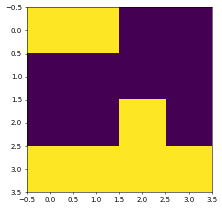

In [39]:
obs = env.reset()
done = False
while not done:
    action = alg._policy(
                    obs=obs,
                    context=None
                )
    obs, reward, done, info = env.step(action)
env.render() 

In [10]:
np.mean(alg._evaluate(env)[0])

/var/folders/6q/zp3bjthx3zv4n0bl2l835qdw0000gn/T/ipykernel_4486/1581625371.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  act= int((self.args.nely*self.args.nelx-1)*action)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


1.1954393843268228e-17